In [1]:
import torch
import torchbearer
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import numpy as np
import pickle
from torchbearer.callbacks import LiveLossPlot
from itertools import product
import gc
from scipy.ndimage import gaussian_filter
import numpy as np
from matplotlib import pyplot as plt
import random
import torch.nn.functional as F
from torch import nn
import sys

In [2]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
# # flatten 28*28 images to a 784 vector for each image
# transform = transforms.Compose([
#     transforms.ToTensor(),  # convert to tensor
# ])
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [4]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)
#split the data
trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]
# # print(trainset.targets[0:11905])
#for distillation
trainloaderforDistillation = DataLoader(trainset, batch_size=1000, shuffle=True)

In [5]:
 # define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc2(out)        
        out = F.relu(out)
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out
# Define the ANN for fine-tuning network
class NetworkControl(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetworkControl, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc2(out)        
        out = F.relu(out)
        out = F.dropout(out, 0.2)        
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out
    
    
class BetterCNNforDistillation(nn.Module):
    def __init__(self):
        super(BetterCNNforDistillation, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=0)
        self.fc1 = nn.Linear(64 * 5**2, 1024)
        self.fc2 = nn.Linear(1024, 50)
        self.fc3 = nn.Linear(50, 10)

            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [11]:
#train distillion network

modelDistillation = BetterCNNforDistillation().to(device)
loss_function = nn.CrossEntropyLoss()
# optimiser = optim.Adam(model.parameters())
optimiser = optim.SGD(modelDistillation.parameters(), lr=0.1, momentum=0.5)
running_loss = 0.0

#teacher network
for epoch in range(2):
    running_loss = 0.0
    for data in trainloaderforDistillation:
        # get the inputs
        inputs, labels = data
        inputs = torch.reshape(inputs, [-1, 1,28,28])
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = modelDistillation(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        
        #update the label for modelDistillation
        if epoch == 1:       
            predictions = torch.argmax(outputs, 1)
            labels = predictions
            
        
        # keep track of the loss this epoch
        running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    pickle.dump(modelDistillation, open('teacher.p', 'wb'))
print('**** Finished Training ****')



Epoch 0, loss 63.22
Epoch 1, loss 51.12
**** Finished Training ****


In [12]:
#student network
for epoch in range(2):
    running_loss = 0.0
    for data in trainloaderforDistillation:
        # get the inputs
        inputs, labels = data
        inputs = torch.reshape(inputs, [-1, 1,28,28])
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = modelDistillation(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step() 
        
        # keep track of the loss this epoch
        running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    pickle.dump(modelDistillation, open('student.p', 'wb'))
print('**** Finished Training ****')

Epoch 0, loss 20.71
Epoch 1, loss 8.78
**** Finished Training ****


In [13]:
modelDistillation.eval()

# Compute the model accuracy on the test set
correct = 0
total = 0

for data in testloader:
    inputs, labels = data
    inputs = torch.reshape(inputs, [-1, 1,28,28])
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = modelDistillation(inputs)
    predictions = torch.argmax(outputs, 1)
    correct += (predictions == labels).sum().float()
    total += len(labels)
print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
torch.save(modelDistillation,'save_dis.pkl')

Test Accuracy: 90.70 %


d:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BetterCNNforDistillation. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [6]:
# initalize data for sleeping network 
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)
#split the data
trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]
# # print(trainset.targets[0:11905])
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [7]:
model = torch.load('save.pkl')
loss_function = nn.CrossEntropyLoss()
# live_loss_plot = LiveLossPlot()
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
# trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[live_loss_plot], metrics=['loss', 'accuracy']).to(device)
trial = torchbearer.Trial(model, optimiser, loss_function,metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 1.5614686012268066, 'test_acc': 0.9386000037193298}


In [8]:
def sleep(model, inputs, scales):
    changenum = 0
    #The parameters like alpha,beta,etc,you can change to find better performance
    num_features = inputs.shape[0]
    Ts = inputs.shape[1]
    dt = 0.01
    InputRate = 40
    sleepDur = inputs.shape[1]
    dec = 0.03
    sleep_inc = 0.0065
    sleep_dec = 0.0069 
    sleep_beta = [15.579, 0.35, 16.52]  
#     25.516308 0.344342 13.197703
    previous_factor = 1
    alpha = 0.98 
    updateswitch = 0
    
    norm_constants = torch.zeros(3,1).cuda(device)
    
    #initalize spiking network
    InputLayer_spikes = torch.zeros(784,1).cuda(device)
    InputLayer_mem = torch.zeros(784,1).cuda(device)
    InputLayer_refrac_end = torch.zeros(784,1).cuda(device)
    InputLayer_sum_spikes = torch.zeros(784,1).cuda(device)
    InputLayer_total_spikes = torch.zeros(sleepDur,784).cuda(device)
    
    fc1_spikes = torch.zeros(1200,1).cuda(device)
    fc1_mem = torch.zeros(1200,1).cuda(device)
    fc1_refrac_end = torch.zeros(1200,1).cuda(device)
    fc1_sum_spikes = torch.zeros(1200,1).cuda(device)
    fc1_total_spikes = torch.zeros(sleepDur,1200).cuda(device)
    
    fc2_spikes = torch.zeros(1200,1).cuda(device)
    fc2_mem = torch.zeros(1200,1).cuda(device)
    fc2_refrac_end = torch.zeros(1200,1).cuda(device)
    fc2_sum_spikes = torch.zeros(1200,1).cuda(device)
    fc2_total_spikes = torch.zeros(sleepDur,1200).cuda(device)

    fc3_spikes = torch.zeros(10,1).cuda(device)
    fc3_mem = torch.zeros(10,1).cuda(device)
    fc3r_refrac_end = torch.zeros(10,1).cuda(device)
    fc3_sum_spikes = torch.zeros(10,1).cuda(device)
    fc3_total_spikes = torch.zeros(sleepDur,10).cuda(device)
    
    ListSpikes = [InputLayer_spikes, fc1_spikes, fc2_spikes, fc3_spikes]
    ListMem = [InputLayer_mem, fc1_mem, fc2_mem, fc3_mem]
    ListRefrac_end= [InputLayer_refrac_end, fc1_refrac_end, fc2_refrac_end, fc3r_refrac_end]
    ListSum_spikes = [InputLayer_sum_spikes, fc1_sum_spikes, fc2_sum_spikes, fc3_sum_spikes]
    ListTotal_spikes = [InputLayer_total_spikes, fc1_total_spikes, fc2_total_spikes, fc3_total_spikes]
    weight = [torch.t(torch.t(model.fc1.weight)), torch.t(torch.t(model.fc2.weight)), torch.t(torch.t(model.fc3.weight))]
#     threshold = [0.03618, 0.02336, 0.03638]  
    
    
    
    #get normalization norm_constants
    for i in range(3):
        weight_max = torch.max(weight[i]);
        if   weight_max<0:
            weight_max = 0
        applied_factor = weight_max / previous_factor
        norm_constants[i] = 1 / applied_factor
        previous_factor = applied_factor
            
    sleep_alpha = norm_constants*alpha
    inp_image = torch.zeros(num_features,1).cuda(device) 
    
    
    for i in range(Ts):
#          Create poisson distributed spikes from the input images
        spike_snapshot = torch.rand(num_features,1) * (1/(dt*InputRate))/2
        for idx in range(num_features):
            if spike_snapshot[idx] <= inputs[idx,i]:
                inp_image[idx] = 1


        ListSpikes[0] = inp_image
        ListSum_spikes[0] = ListSum_spikes[0]  + inp_image
        ListTotal_spikes[0][i,:] = torch.t(ListSpikes[0])  

        for i in range(1,4):

#             Get input impulse from incoming spike(lose some parameters)
            impulse = sleep_alpha[i-1] * torch.t(ListSpikes[i-1]) @ torch.t(weight[i-1])
#             Add input to membrane potential

            decMem = dec * ListMem[i]
            decMem =decMem.cuda(device)
            ListMem[i] = decMem + torch.t(impulse)
            if i == 3:
                ListMem[i] = ListMem[i]


            if(i == 1):
                print("the max of first layer", torch.max(ListMem[i]))
            if(i == 2):
                print("the max of second layer", torch.max(ListMem[i]))
            if(i == 3):
                print("the max of third layer", torch.max(ListMem[i]))

#           Check for spiking     
            for j in range (ListMem[i].shape[0]):
                if ListMem[i][j] >= sleep_beta[i-1]:
                    ListSpikes[i][j] = 1
                else:
                    ListSpikes[i][j] = 0

            post_1 = []  
            pre_1 = []
            pre_0 = []
#           STDP
            for j in range(ListSpikes[i].shape[0]):
                if ListSpikes[i][j] == 1:
                    print(j)
                    post_1.append(j)                  
            for j in range(ListSpikes[i-1].shape[0]):
                if ListSpikes[i-1][j] == 1:
                    pre_1.append(j)                
                else:
                    pre_0.append(j)

#             print("1",len(post_1))
#             print("2",len(pre_1))
#             print(list(product(post_1,pre_1)))
#             print(len(pre_0))

            for idex in list(product(post_1,pre_1)):
                updateswitch = 1                         
                weight[i-1][idex] = weight[i-1][idex]  - sleep_dec * torch.sigmoid(weight[i-1][idex] )
            for idex in list(product(post_1,pre_0)):
                updateswitch = 1                                        
                weight[i-1][idex] = weight[i-1][idex]  + sleep_inc * torch.sigmoid(weight[i-1][idex] )

            print("The status of switch is ",updateswitch)
            if updateswitch == 1:
                if i == 1:
                    changenum +=1
                    fc1_new_weight=torch.nn.Parameter(weight[0])
                    model.fc1.weight = fc1_new_weight
                if i == 2:
                    changenum +=1
                    fc2_new_weight=torch.nn.Parameter(weight[1])
                    model.fc2.weight = fc2_new_weight
                if i == 3:
                    changenum +=1
                    fc3_new_weight=torch.nn.Parameter(weight[2])
                    model.fc3.weight = fc3_new_weight

            updateswitch = 0  #reset switch                  

            #reset
            for j in range(ListSpikes[i].shape[0]):
                if ListSpikes[i][j] == 1:
                    ListMem[i][j] = 0
            
            #To save the memory space, we just see what happened after the weight changed 10times( here means total 6 layers' wight changed)
            if changenum >= 20:
                print("changenum is ",changenum)
                sys.exit(0)

In [9]:
i = 0
for data in trainloader:
        # get the inputs
    inputs, labels = data
    inputs = inputs.cuda(device)
    labels = labels.cuda(device)
    sleep(model, torch.t(inputs),1)

the max of first layer tensor(9.6672, device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of second layer tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of third layer tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of first layer tensor(10.4563, device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of second layer tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of third layer tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of first layer tensor(16.2044, device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  1
the max of second layer tensor(0.0549, device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of third layer tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
The status of switch is  0
the max of first layer tensor(16.0932, device='cuda:0', grad_

SystemExit: 0

d:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3333: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
loss_function = nn.CrossEntropyLoss()
# live_loss_plot = LiveLossPlot()
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)


{'test_loss': 1.5686533451080322, 'test_acc': 0.9354999661445618}


In [11]:
torch.save(model,'save2.pkl')
# model = torch.load('save2.pkl')

d:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BaselineModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
#plot

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)
trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]

sigma_values = [0, 0.5, 1.0, 1.5, 2.0, 2.5]
variance_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
blur_acc_control = []
blur_acc_sleep = []
blur_acc_finetune_noise = []
blur_acc__finetune_blur = []
blur_acc_dis = []
noise_acc_control = []
noise_acc_sleep = []
noise_acc_finetune_noise = []
noise_acc__finetune_blur = []
noise_acc_dis = []

for i in range(len(sigma_values)):
    
    j = i
    
    #blur data
    trainset = MNIST(".", train=True, download=True, transform=transform)
    testset = MNIST(".", train=False, download=True, transform=transform)
    trainset.data = trainset.data[0:27105]
    trainset.targets = trainset.targets[0:27105]



    # function to blur each MNIST image
    def blur(x, sig):
        return gaussian_filter(x, sigma=sig)
    

    # Distort the test set #
    for i in range(len(testset)):
        # gaussian blur the image with the chosen sigma value
        blurredImage = blur(testset.test_data[i].numpy(), sigma_values[j])
        # update the training set with the blurred image
        testset.test_data[i] = torch.from_numpy(blurredImage)
    
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=True)
    
    #test the controlled network
    model = torch.load('save.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    # trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[live_loss_plot], metrics=['loss', 'accuracy']).to(device)
    trial = torchbearer.Trial(model, optimiser, loss_function,metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_control.append(100.0 * results["test_acc"])
    
    #test the sleeping network
    model = torch.load('save2.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    # trial = torchbearer.Trial(model, optimiser, loss_function, callbacks=[live_loss_plot], metrics=['loss', 'accuracy']).to(device)
    trial = torchbearer.Trial(model, optimiser, loss_function,metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_sleep.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-blur network
    model = torch.load('save_blur.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc__finetune_blur.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-noise network
    model = torch.load('save_noise.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    blur_acc_finetune_noise.append(100.0 * results["test_acc"])
    
    #test the distillion network
    model = torch.load('save_dis.pkl')
    model.eval()

    # Compute the model accuracy on the test set
    correct = 0
    total = 0

    for data in testloader:
        inputs, labels = data
        inputs = torch.reshape(inputs, [-1, 1,28,28])
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, 1)
        correct += (predictions == labels).sum().float()
        total += len(labels)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    blur_acc_dis.append(((100.0 * correct) / total).item())
    
    
    
    #noise data
    trainset = MNIST(".", train=True, download=True, transform=transform)
    testset = MNIST(".", train=False, download=True, transform=transform)
    trainset.data = trainset.data[0:27105]
    trainset.targets = trainset.targets[0:27105]
    
    def noise(x, var):
        return x + var * x.std() * np.random.random(x.shape)

    for i in range(len(testset)):
        # add gaussian noise to the image with the chosen variance value
        noisyImage = noise(testset.test_data[i].numpy(), variance_values[j])
        # update the training set with the noise image
        testset.test_data[i] = torch.from_numpy(noisyImage)
    
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = DataLoader(testset, batch_size=128, shuffle=True)
    
    #test the controlled network
    model = torch.load('save.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_control.append(100.0 * results["test_acc"])
    
    #test the sleeping network
    model = torch.load('save2.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_sleep.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-blur network
    model = torch.load('save_blur.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc__finetune_blur.append(100.0 * results["test_acc"])
    
    #test the fine-tuning-noise network
    model = torch.load('save_noise.pkl')
    loss_function = nn.CrossEntropyLoss()
    # live_loss_plot = LiveLossPlot()
    optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(trainloader, test_generator=testloader)
    results = trial.evaluate(data_key=torchbearer.TEST_DATA)
    print(results)
    noise_acc_finetune_noise.append(100.0 * results["test_acc"])
    
    #test the distillion network
    model = torch.load('save_dis.pkl')
    model.eval()
    # Compute the model accuracy on the test set
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data
        inputs = torch.reshape(inputs, [-1, 1,28,28])
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, 1)
        correct += (predictions == labels).sum().float()
        total += len(labels)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    noise_acc_dis.append(((100.0 * correct) / total).item())

C:\Users\ZLY\AppData\Roaming\Python\Python37\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")



{'test_loss': 1.561848521232605, 'test_acc': 0.9384999871253967}



{'test_loss': 1.5691115856170654, 'test_acc': 0.9352999925613403}



{'test_loss': 1.6021250486373901, 'test_acc': 0.8988999724388123}



{'test_loss': 1.6052275896072388, 'test_acc': 0.8833999633789062}
Test Accuracy: 90.76 %



{'test_loss': 1.5621687173843384, 'test_acc': 0.9378999471664429}



{'test_loss': 1.5694202184677124, 'test_acc': 0.9332000017166138}



{'test_loss': 1.6031575202941895, 'test_acc': 0.8999999761581421}



{'test_loss': 1.6061040163040161, 'test_acc': 0.8842999935150146}
Test Accuracy: 91.15 %



{'test_loss': 1.5661042928695679, 'test_acc': 0.9375999569892883}



{'test_loss': 1.5717778205871582, 'test_acc': 0.934499979019165}



{'test_loss': 1.6054826974868774, 'test_acc': 0.8988999724388123}



{'test_loss': 1.6100046634674072, 'test_acc': 0.8804000020027161}
Test Accuracy: 90.77 %



{'test_loss': 1.8175864219665527, 'test_acc': 0.8381999731063843}



{'test_loss': 1.8208187818527222, 'test_acc': 0.8452999591827393}



{'test_loss': 1.8074508905410767, 'test_acc': 0.8075999617576599}



{'test_loss': 1.7233253717422485, 'test_acc': 0.8366999626159668}
Test Accuracy: 75.61 %



{'test_loss': 1.5904748439788818, 'test_acc': 0.9304999709129333}



{'test_loss': 1.592949390411377, 'test_acc': 0.9330999851226807}



{'test_loss': 1.6168115139007568, 'test_acc': 0.8947999477386475}



{'test_loss': 1.6267756223678589, 'test_acc': 0.8718999624252319}
Test Accuracy: 89.90 %



{'test_loss': 1.9320011138916016, 'test_acc': 0.7375999689102173}



{'test_loss': 1.9259599447250366, 'test_acc': 0.7675999999046326}



{'test_loss': 1.9016832113265991, 'test_acc': 0.7181000113487244}



{'test_loss': 1.7711987495422363, 'test_acc': 0.8068000078201294}
Test Accuracy: 68.62 %



{'test_loss': 1.648491621017456, 'test_acc': 0.9062999486923218}



{'test_loss': 1.64439857006073, 'test_acc': 0.9174999594688416}



{'test_loss': 1.6455990076065063, 'test_acc': 0.8819999694824219}



{'test_loss': 1.6635234355926514, 'test_acc': 0.8499000072479248}
Test Accuracy: 87.24 %



{'test_loss': 2.0109992027282715, 'test_acc': 0.6373999714851379}



{'test_loss': 1.9996622800827026, 'test_acc': 0.6705999970436096}



{'test_loss': 1.9776962995529175, 'test_acc': 0.6251999735832214}



{'test_loss': 1.8063191175460815, 'test_acc': 0.7805999517440796}
Test Accuracy: 62.37 %



{'test_loss': 1.7502870559692383, 'test_acc': 0.8402000069618225}



{'test_loss': 1.7296216487884521, 'test_acc': 0.8876000046730042}



{'test_loss': 1.6936529874801636, 'test_acc': 0.863599956035614}



{'test_loss': 1.7288285493850708, 'test_acc': 0.8011999726295471}
Test Accuracy: 82.28 %



{'test_loss': 2.0734546184539795, 'test_acc': 0.5303999781608582}



{'test_loss': 2.062990188598633, 'test_acc': 0.5622999668121338}



{'test_loss': 2.0440280437469482, 'test_acc': 0.519599974155426}



{'test_loss': 1.8434628248214722, 'test_acc': 0.7480999827384949}
Test Accuracy: 55.15 %



{'test_loss': 1.879044771194458, 'test_acc': 0.7124999761581421}



{'test_loss': 1.8436518907546997, 'test_acc': 0.8330999612808228}



{'test_loss': 1.7680000066757202, 'test_acc': 0.8307999968528748}



{'test_loss': 1.8210514783859253, 'test_acc': 0.714199960231781}
Test Accuracy: 74.60 %



{'test_loss': 2.127370834350586, 'test_acc': 0.4293999969959259}



{'test_loss': 2.1217362880706787, 'test_acc': 0.44759997725486755}



{'test_loss': 2.1024491786956787, 'test_acc': 0.41849997639656067}



{'test_loss': 1.8847761154174805, 'test_acc': 0.70169997215271}
Test Accuracy: 47.47 %


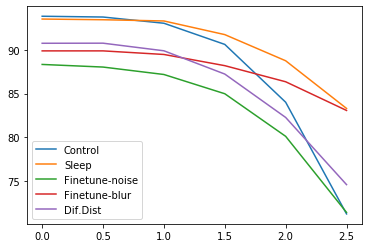

In [13]:


plt.plot(sigma_values, blur_acc_control, label='Control')
plt.plot(sigma_values, blur_acc_sleep, label='Sleep')
plt.plot(sigma_values, blur_acc_finetune_noise, label='Finetune-noise')
plt.plot(sigma_values, blur_acc__finetune_blur, label='Finetune-blur')
plt.plot(sigma_values, blur_acc_dis, label='Dif.Dist')
plt.legend()
plt.show()

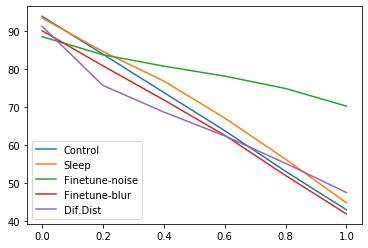

In [14]:
plt.plot(variance_values, noise_acc_control, label='Control')
plt.plot(variance_values, noise_acc_sleep, label='Sleep')
plt.plot(variance_values, noise_acc_finetune_noise, label='Finetune-noise')
plt.plot(variance_values, noise_acc__finetune_blur, label='Finetune-blur')
plt.plot(variance_values, noise_acc_dis, label='Dif.Dist')
plt.legend()
plt.show()